# Exploraci√≥n de Datos: Letras Est√°ticas

Este notebook realiza un an√°lisis exploratorio (EDA) sobre el dataset de letras est√°ticas en Lengua de Se√±as Mexicana (LSM). Exploramos la distribuci√≥n de clases, calidad de las im√°genes, sus dimensiones, y verificamos su validez para prepararlas para entrenamiento.

In [17]:
from pyprojroot import here
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

# Configuraci√≥n general
plt.style.use("seaborn-v0_8-whitegrid")

# Cargar dataset
csv_path = here() / "data" / "letters" / "letter_labels.csv"
df = pd.read_csv(csv_path)
df.head()

image_path label
0    data/letters/statics/A/S1-A-4-0.jpg     A
1    data/letters/statics/A/S1-A-4-1.jpg     A
2   data/letters/statics/A/S1-A-4-10.jpg     A
3  data/letters/statics/A/S1-A-4-100.jpg     A
4  data/letters/statics/A/S1-A-4-101.jpg     A

## Distribuci√≥n de Clases

Graficamos cu√°ntas im√°genes hay por cada letra del abecedario para identificar posibles desbalances.

C:\Users\Jamin\AppData\Local\Temp\ipykernel_23820\2296821275.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="label", order=sorted(df['label'].unique()), palette="viridis")


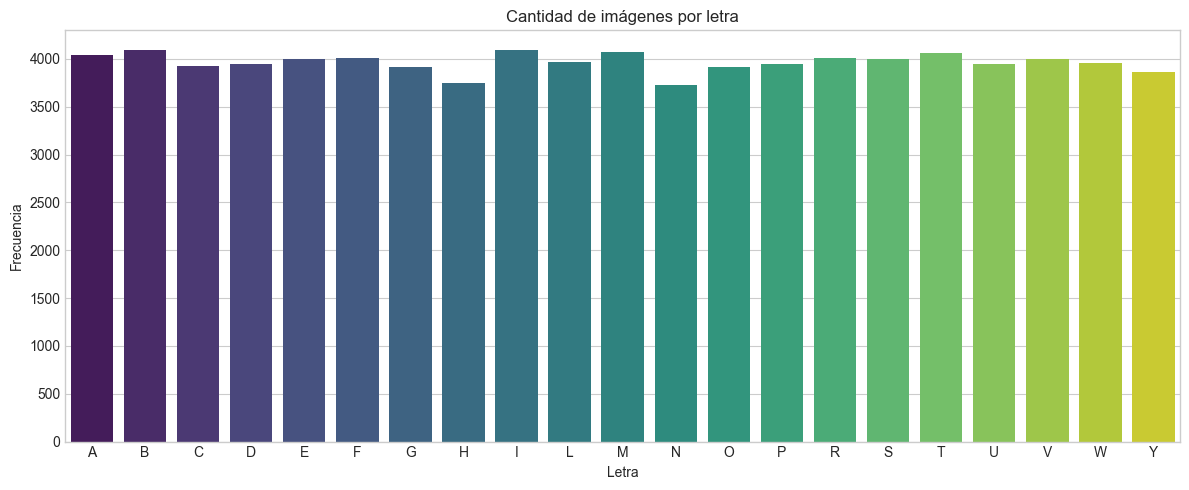

In [18]:
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x="label", order=sorted(df['label'].unique()), palette="viridis")
plt.title("Cantidad de im√°genes por letra")
plt.xlabel("Letra")
plt.ylabel("Frecuencia")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Visualizaci√≥n de muestras

Mostraremos una imagen representativa por cada letra para verificar la calidad y diversidad del dataset.

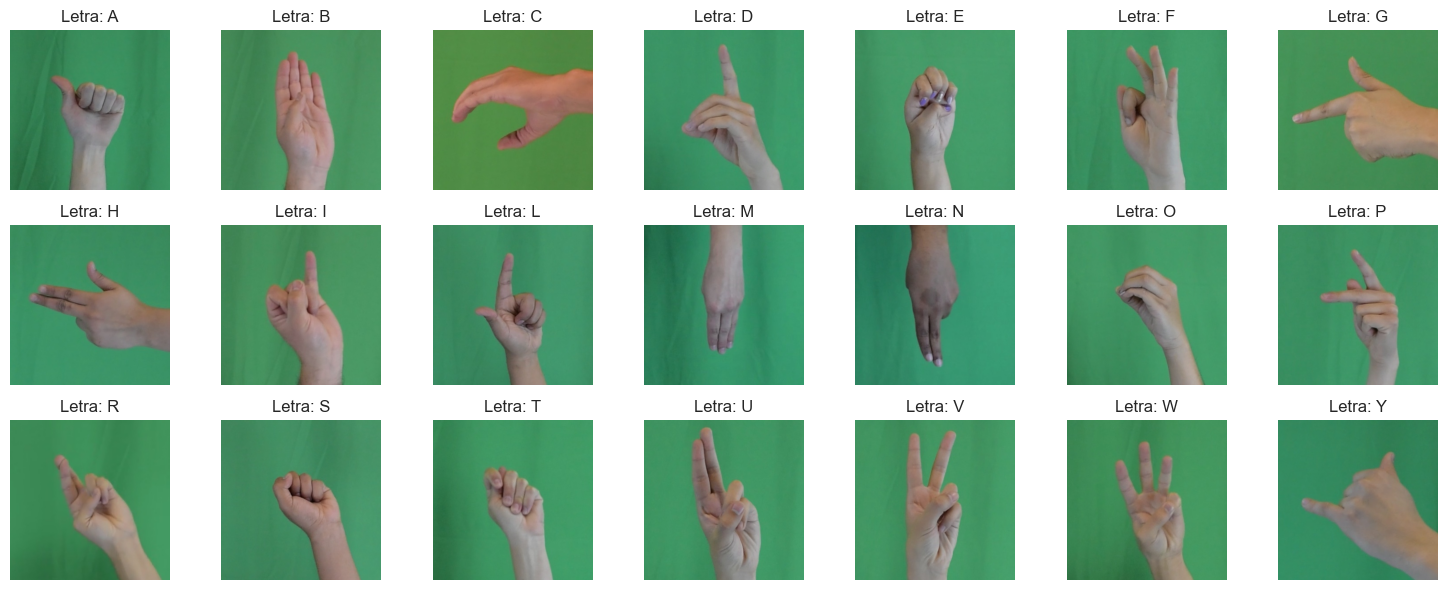

In [19]:
letters = sorted(df['label'].unique())
n = len(letters)

fig, axes = plt.subplots(3, (n + 2) // 3, figsize=(15, 6))
axes = axes.flatten()

for i, letra in enumerate(letters):
    sample_path = df[df['label'] == letra].sample(1)['image_path'].values[0]
    img_path = here() / Path(sample_path)
    
    if not img_path.exists():
        print(f"‚ùå Imagen no encontrada: {img_path}")
        continue

    img = cv2.imread(str(img_path))
    if img is None:
        print(f"‚ö†Ô∏è Error al cargar: {img_path}")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(f"Letra: {letra}")
    axes[i].axis('off')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Tama√±o de Im√°genes

Analizamos las dimensiones de todas las im√°genes para ver si necesitan ser redimensionadas.

In [20]:
sizes = []
errores = []

for path in df["image_path"]:
    img_path = here() / path
    img = cv2.imread(str(img_path))
    if img is not None:
        h, w = img.shape[:2]
        sizes.append((w, h))
    else:
        errores.append(str(img_path))

size_df = pd.DataFrame(sizes, columns=["width", "height"])
print(f"‚úÖ {len(size_df)} im√°genes cargadas correctamente.")
print(f"‚ùå {len(errores)} im√°genes con error de lectura.")

‚úÖ 83264 im√°genes cargadas correctamente.
‚ùå 0 im√°genes con error de lectura.


## Distribuci√≥n de Tama√±os

Visualizamos la distribuci√≥n de anchos y altos para decidir un tama√±o uniforme.

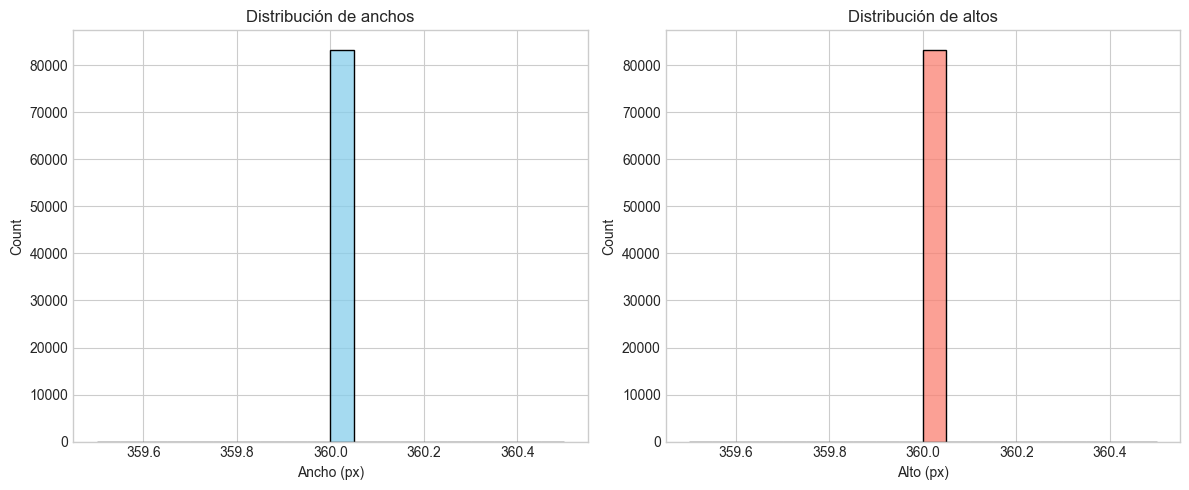

In [21]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(size_df["width"], bins=20, kde=False, color="skyblue")
plt.title("Distribuci√≥n de anchos")
plt.xlabel("Ancho (px)")

plt.subplot(1, 2, 2)
sns.histplot(size_df["height"], bins=20, kde=False, color="salmon")
plt.title("Distribuci√≥n de altos")
plt.xlabel("Alto (px)")

plt.tight_layout()
plt.show()

In [22]:
# Tama√±os unicos Mas Comunes
unique_sizes = size_df.value_counts().reset_index(name="count")
unique_sizes.columns = ["width", "height", "count"]
unique_sizes.head(10)

width  height  count
0    360     360  83264

## Reducci√≥n de dimensionalidad con PCA + UMAP
Para visualizar mejor la distribuci√≥n y separabilidad entre clases, se aplic√≥ una combinaci√≥n de PCA (An√°lisis de Componentes Principales) y UMAP (Uniform Manifold Approximation and Projection). Dado el alto costo computacional de trabajar con im√°genes de 360√ó360 p√≠xeles, se redimensionaron previamente a 64√ó64 para reducir el consumo de memoria sin perder la forma general de los gestos.

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 83264/83264 [03:02<00:00, 455.94it/s]
c:\Users\Jamin\miniconda3\envs\signml\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Jamin\miniconda3\envs\signml\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Jamin\miniconda3\envs\signml\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


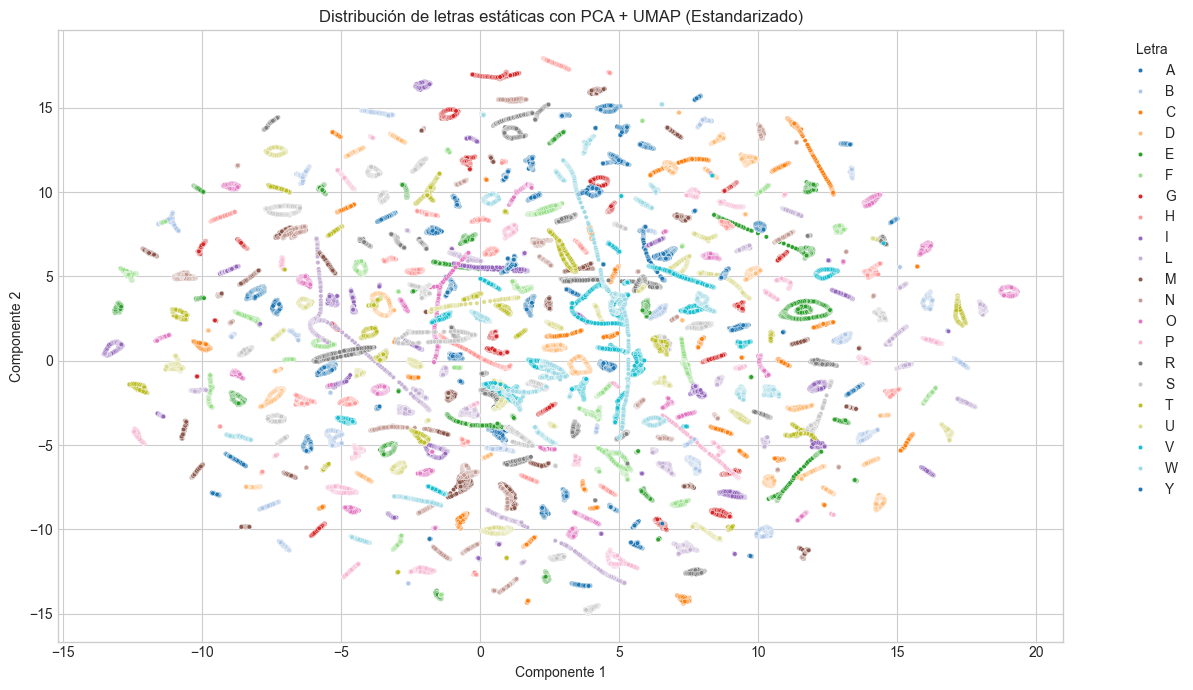

In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap
from tqdm import tqdm
import numpy as np

# ‚Üì‚Üì‚Üì Par√°metros ‚Üì‚Üì‚Üì
target_size = (64, 64)  # Nueva resoluci√≥n

# Cargar y reducir tama√±o de las im√°genes
images = []
labels = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    img = cv2.imread(str(here() / row["image_path"]), cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img_small = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        images.append(img_small.flatten())
        labels.append(row["label"])

X = np.array(images)
y = np.array(labels)

# üîπ Estandarizaci√≥n antes de PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# üî∏ Paso 1: PCA
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

# üî∏ Paso 2: UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_pca)

# Visualizaci√≥n
df_umap = pd.DataFrame({
    "x": X_umap[:, 0],
    "y": X_umap[:, 1],
    "label": y
})

plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_umap, x="x", y="y", hue="label", palette="tab20", s=10)
plt.title("Distribuci√≥n de letras est√°ticas con PCA + UMAP (Estandarizado)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend(title="Letra", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Conclusiones

- El CSV fue generado correctamente con rutas y etiquetas v√°lidas.
- Todas las im√°genes se cargaron sin errores.
- Las clases est√°n balanceadas en cantidad de im√°genes.
- Las im√°genes tienen buena calidad visual y fondo uniforme.
- Todas las im√°genes tienen la misma dimensi√≥n (360x360 p√≠xeles).
- Se dispone de un total de 83,264 im√°genes para entrenamiento.
- El an√°lisis de reducci√≥n de dimensionalidad mediante PCA + UMAP mostr√≥ una mejor separabilidad entre clases, lo cual sugiere una buena base para clasificaci√≥n visual.